<a href="https://colab.research.google.com/github/JakobSchauser/BachelorProject-IceCube-ML/blob/main/Neutrino_regression_using_the_base_of_Fifth_Working_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spektral -q
!pip install ipynb

import numpy as np
import tensorflow as tf
import keras
import pickle
import spektral

%cd "/content/drive/MyDrive/Colab Notebooks/"
%run J_utilities.ipynb
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import MeanAbsoluteError as MeanAbsoluteError_acc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.sparse import SparseTensor
 
from keras import backend as K
 
from time import time
 
 
from spektral.data import DisjointLoader, Dataset
from spektral.datasets import QM9
from spektral.layers import AGNNConv, GlobalSumPool, GlobalMaxPool, GlobalAvgPool, GCNConv, ECCConv
from spektral import transforms
 
from tqdm.notebook import tqdm
 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
 
PI = np.pi
 
 
# Lifehack
true = True
false = False

     |████████████████████████████████| 122kB 19.3MB/s 


ERROR:root:File `'J_utilities.ipynb.py'` not found.


/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install wandb -q

import wandb
from wandb.keras import WandbCallback

wandb.login()

     |████████████████████████████████| 2.0MB 20.7MB/s 
     |████████████████████████████████| 133kB 54.3MB/s 
     |████████████████████████████████| 102kB 13.0MB/s 
     |████████████████████████████████| 163kB 51.7MB/s 
     |████████████████████████████████| 71kB 10.3MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
################################################################################
# LOAD DATA
################################################################################
# Find the reverse transformer
pcl = "/content/drive/MyDrive/Bachelor Project - IceCube ML/transformers.pkl"

with open(pcl,'rb') as tra:
    transformer = pickle.load(tra)

transformer = transformer["truth"]


class dat(Dataset):
  def __init__(self,n = 1,**kwargs):
    self.n = n
    super().__init__(**kwargs)
  def read(self):
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergy100000 0.npz" # Uncleaned
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/generatedDataAnglesEnergyClean200000events 0.npz" # Cleaned
    path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/HEPGeneratedneutrino33333events.npz" # osc-next
    # path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/data.dat" # From Severin
    dataset = np.load(path,allow_pickle = True)["arr_0"]
    graphs = []
    for g in dataset:
      e,a,z = g["y"]
      # g["y"] = [transformer['energy_log10'].inverse_transform([[e]])[0][0],transformer['azimuth'].inverse_transform([[a]])[0][0]-PI,transformer['zenith'].inverse_transform([[z]])[0][0]]
      graphs.append(g)
    return np.array(dataset)

dataset = dat()

print("Dataset is", dataset, "consisting of", dataset[0])




#### Put on GPU when possible
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("Running on GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Running on CPU")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RobustScaler from version 0.19.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Dataset is dat(n_graphs=33333) consisting of Graph(n_nodes=17, n_node_features=5, n_edge_features=None, n_labels=3)
Running on GPU


In [ ]:
m = 0
for d in dataset:
  if d.n_nodes > m:
    m = d.n_nodes
print(m)

542


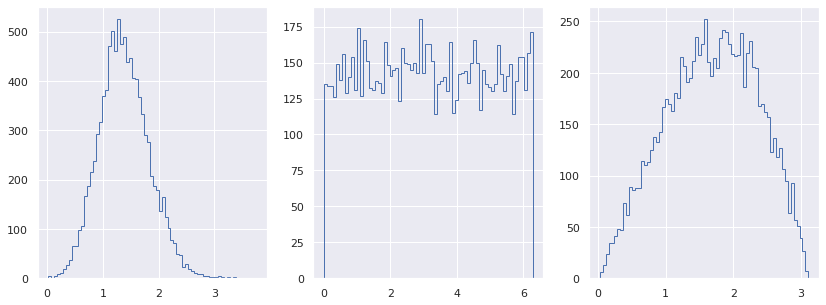

In [ ]:

fig, axs = plt.subplots(1,3,figsize=(14,5))

N = 10000

trs = np.empty((N,3))
for k in range(N):
  trs[k] = dataset[k]["y"]

for k in range(3):
  axs[k].hist(trs[:,k],histtype="step",bins = 70)

In [ ]:
# from spektral.transforms import GCNFilter

# t = time.time()
# dataset.apply(GCNFilter())
# print(f"Goddamn, this takes {t-time.time():.3} seconds!")

In [ ]:
def custom_loss(target,predictions):
    predictions = tf.cast(predictions,"float64")


    azi  = [tf.cos(target[:,1]) - predictions[:,0], 
            tf.sin(target[:,1]) - predictions[:,1]]

    # zeni = [tf.cos(target[:,2]) - predictions[:,2], 
    #         tf.sin(target[:,2]) - predictions[:,3]]


    loss = 0
    loss += tf.reduce_mean(tf.math.abs(azi[0]))
    loss += tf.reduce_mean(tf.math.abs(azi[1]))
    # loss += tf.reduce_mean(tf.math.abs(zeni[0]))
    # loss += tf.reduce_mean(tf.math.abs(zeni[1]))
    return loss

loss_fn = custom_loss


def custom_acc(target,predictions):
    predictions = tf.cast(predictions,"float64")

    

    aziguess = tf.atan2(predictions[:,1],predictions[:,0])
    azi = tf.minimum( tf.abs(target[:,1] - aziguess) , tf.abs(tf.abs(target[:,1] - aziguess) - 2*PI))

    zeniguess = tf.atan2(predictions[:,3],predictions[:,2])
    zeni = tf.minimum( tf.abs(target[:,2] - zeniguess) , tf.abs(tf.abs(target[:,2] - zeniguess) - 2*PI))
    
    azi = tf.reduce_mean(azi)
    zeni = tf.reduce_mean(zeni)

    return (azi,zeni)

acc_fn = custom_acc

def scale_inputs(inputs):
    inputs[0][:,:3] = inputs[0][:,:3]/100 # x y z
    inputs[0][:,3] = inputs[0][:,3]/10000 # time
    inputs[0][:,4] = inputs[0][:,4]/1 # charge
    return inputs


def lr_schedule(start_lr,epoch,total_epochs):
  return start_lr/((1+epoch/total_epochs)*5)
  if epoch < total_epochs//4:
    return start_lr*(1+epoch/(total_epochs//4))
  return 2*start_lr/(10*epoch/total_epochs)

In [ ]:
################################################################################
# PARAMETERS
################################################################################
#@markdown ### Define the model and training parameters and sync with WandB
batch_size =  16#@param {type: "number"}
 
# one-variable network size changer
network_size =  32#@param {type: "number"}
 
learning_rate = 1e-5  #@param {type: "number"}
 
training_epochs = 60 #@param {type: "slider", min: 10, max: 200}
 
early_stopping_rounds =  4#@param {type: "number"}
 
dropout_rate = 0.2 #@param {type: "number"}
 
loss_function = "rasmus_loss"   #@param ['custom_loss',"rasmus_loss","binary_cross_entropy","von_mises_fisher"]
 
config = {
        "learning_rate": learning_rate,
        "epochs": training_epochs,
        "batch_size": batch_size,
        "loss_function": loss_function,
        "architecture": "Broadening CNN - short but wide",
        "network_size": network_size,
        "dropout_rate": dropout_rate,
        "dataset": "MuonGun",
        "early_stopping_rounds": early_stopping_rounds,
      }
 
epochs = config["epochs"]  # Number of training epochs
test_epochs = 2 # Number of testing epochs

In [ ]:
# Parameters
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
# n_out = dataset.n_labels  # Dimension of the target
n_out = 4

# Train/test split
idxs = np.random.permutation(len(dataset))
split = int(0.9 * len(dataset))
idx_tr, idx_te = np.split(idxs, [split])
dataset_tr, dataset_te = dataset[idx_tr], dataset[idx_te]

train_loader = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, shuffle=True)
test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)





class model_class(Model):
  def __init__(self):
    super().__init__()
    
    self.preprocess = transforms.layer_preprocess.LayerPreprocess(GCNConv)

    self.inp = ECCConv(network_size)

    self.steps = [2**i for i in range(4)][::-1]
    self.convs = [GCNConv(network_size*s,activation="gelu") for s in self.steps]

    self.maxpool = GlobalMaxPool()
    self.avgpool = GlobalAvgPool()
    self.sumpool = GlobalSumPool()

    self.denses = [Dense(network_size*s,activation= "gelu") for s in self.steps[::-1]]
    self.dropouts = [Dropout(dropout_rate) for s in self.steps]
    # self.normalizations = [BatchNormalization() for s in self.steps]

    self.out = Dense(n_out)#,activation="softsign")
    # self.oneout = Dense(1)

  def call(self, inputs, training = False):

    x, a, i = inputs
    e    = self.generate_edge_features(x, a) 
    x = self.inp([x,a,e])
    # a = self.preprocess(a)

    self.poolglobal = []

    inform = [tf.math.segment_mean(x,i),
              tf.math.segment_min(x,i),
              tf.math.segment_max(x,i)]

    for conv in self.convs:
      x = conv([x,a])
    
    
    xm = self.maxpool([x,i])
    xa = self.avgpool([x,i])
    xs = self.sumpool([x,i])

    x = tf.concat([xm, xa, xs,*inform], axis = 1) 


    for dense, dropout in zip(self.denses,self.dropouts):
      # x = norm(x) # ,training = training # batch_normalization is broken in curretn keras
      x = dense(x)
      x = dropout(x,training = training)


    out = self.out(x)*3

    # xe = self.smalldense(x)
    # xa = self.smalldense(x)
    # xz = self.smalldense(x)

    # oute = self.oneout(xe)
    # outa1 = self.oneout(xa)
    # outa2 = self.oneout(xa)

    # outz1 = self.oneout(xz)
    # outz2 = self.oneout(xz)


    return out
    # return tf.concat([oute, outa1,outa2, outz1,outz2], axis = 1) 


  #Shamelessly stolen from Johann
  def generate_edge_features(self, x, a):
      send    = a.indices[:, 0]
      receive = a.indices[:, 1]

      diff_x  = tf.subtract(tf.gather(x, receive), tf.gather(x, send))

      dists   = tf.sqrt(
        tf.reduce_sum(
          tf.square(
            diff_x[:, :3]
          ), axis = 1
        ))

      vects = tf.math.divide_no_nan(diff_x[:, :3], tf.expand_dims(dists, axis = -1))

      e = tf.concat([diff_x[:, 3:], tf.expand_dims(dists, -1), vects], axis = 1)

      return e

# Build model
model = model_class()

opt = Adam(lr=learning_rate)
loss_fn = custom_loss
# loss_fn = MeanAbsoluteError()
acc_fn = custom_acc






model.compile()
# model.build()
# fit(train_loader)

In [ ]:
################################################################################
# DEFINE TF-FUNCTIONS
################################################################################
@tf.function(input_signature=train_loader.tf_signature(), experimental_relax_shapes=True)
def train_step(inputs, target):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions)
        loss += sum(model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(gradients, model.trainable_variables))
    acc = acc_fn(target,predictions)

    return loss, acc

def validate(inputs,target):
    predictions = model(inputs, training=False)
    loss = loss_fn(target, predictions)
    loss += sum(model.losses)
    acc = acc_fn(target,predictions)

    return loss, acc






loss_fn = custom_loss
acc_fn = custom_acc
def fit(train_loader,logwandb = False):
  if logwandb:
    run = wandb.init(project='IceCube OscNext',config = config)

  current_batch = 0
  model_loss = []
  model_acc = []
  vali_loss = []
  epoch = 0

  earlystop = 0
  should_stop = False

  epoch_steps = train_loader.steps_per_epoch

  t = tqdm(total  = train_loader.steps_per_epoch,leave = True, ncols='70%')
  t.set_description(f'Currently on epoch {0} of {epochs} ')

  pb = []
  tar = []
  step = 0

  last_loss = 0
  
  for batch in train_loader:
      if should_stop:
        print("Ending fitting because of early stopping")
        break

      step += 1
      inputs, target = batch
      inputs = scale_inputs(inputs)

      loss, acc = train_step(inputs,target)

      model_loss.append(loss)
      model_acc.append(acc)
      current_batch += 1
      t.update(1)

      if step%10 == 0:
        t.set_description(f'Current loss {np.mean(model_loss):.3} | Working on epoch {epoch} of {epochs}:')

      if current_batch == epoch_steps:
          test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=test_epochs, shuffle=True)
          t.set_description(f'Currently validating results for epoch {epoch} of {epochs}:')

          for vali_batch in test_loader:
            vali_inputs, vali_target = vali_batch
            valie_inputs = scale_inputs(vali_inputs)
            valoss, vaacc = validate(vali_inputs,vali_target)
            vali_loss.append(valoss)
          va = np.mean(vali_loss)

          m_loss = np.mean(model_loss)
          change = (m_loss-last_loss)/max(0.000001,last_loss)
          last_loss = m_loss

          s = "Train loss: {} - Loss change {:+.3f}% | Validation loss {} | Epoch: {}".format(m_loss, change*100,va, epoch)
          t.write(s)

          if m_loss < va:
            if earlystop < early_stopping_rounds:
              earlystop += 1
            else:
              should_stop = True
          else:
            earlystop = 0



          if epoch%10 == 0:
            # maybe write a saving state here
            pass
          ma = np.array(model_acc)
          a,z = np.mean(ma[:,0]) ,np.mean(ma[:,1])

          s = "Accuracy is: Azimuth {} | Zenith {}\n".format(a,z)
          t.write(s)
          # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])

          # if epoch%5 == 0 and epoch != 0:
            # print("Two current guesses are\n",np.array(pb[0]),np.array(pb[1]),"for\n",tar[0],tar[1])
            # pass
          # else:
            # pb = model(inputs, training=False)
            # tar = target



          if logwandb:
            wandb.log({
                      "train_loss": m_loss,
                      "azimuth_accuracy": np.mean(ma[:,0]),
                      "zenith_accuracy": np.mean(ma[:,1]),
                      "val_loss": va,
                      })




          model_loss = []
          model_acc = []
          vali_loss = []
          current_batch = 0
          step = 0

          t.n = 0
          t.last_print_n = 0
          t.refresh()

          epoch += 1


          K.set_value(model.optimizer.learning_rate, lr_schedule(learning_rate,epoch,epochs))




In [ ]:
logwandb = False

fit(train_loader,logwandb = logwandb)

print("\n\nTraining of the following model is now complete:")
model.summary()
save_path = "/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models"


if logwandb:
  pth = save_path + f"/{wandb.run.name}-run"
  wandb.run.finish()  
else:
  pth = save_path + "/Unlogged model"

model.save(pth)

Train loss: 1315.925332781734 - Loss change +131592533278.173% | Validation loss 122.69741632577433 | Epoch: 0
Accuracy is: Azimuth 1.565543855512574 | Zenith 1.4368876226869176

Train loss: 481.9261878430096 - Loss change -63.377% | Validation loss 161.27351107196478 | Epoch: 1
Accuracy is: Azimuth 1.5647467573033356 | Zenith 1.4409073514465935

Train loss: 354.0077389230018 - Loss change -26.543% | Validation loss 65.17811166332713 | Epoch: 2
Accuracy is: Azimuth 1.5733872867516276 | Zenith 1.4535930097303378

Train loss: 249.76770417895474 - Loss change -29.446% | Validation loss 180.80969650184184 | Epoch: 3
Accuracy is: Azimuth 1.5776605744312113 | Zenith 1.4404132114807284

Train loss: 234.66873385436077 - Loss change -6.045% | Validation loss 69.465424958702 | Epoch: 4
Accuracy is: Azimuth 1.5748633699158239 | Zenith 1.430787137833983

Train loss: 135.34504804297336 - Loss change -42.325% | Validation loss 94.66569319443371 | Epoch: 5
Accuracy is: Azimuth 1.5694402887287808 | Ze

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/Unlogged model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/Unlogged model/assets


In [ ]:

model = keras.models.load_model("/content/drive/MyDrive/Bachelor Project - IceCube ML/Saved Models/devout-rain-73-run")

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_predictions(inputs,target):
  return model(inputs,training = False)

@tf.function(input_signature=test_loader.tf_signature(), experimental_relax_shapes=True)
def get_true_guesses(inputs,target):
  pred = model(inputs,training = False)
  energy = pred[:,0]
  azi  = tf.atan2(pred[:,2],pred[:,1])
  zeni = tf.atan2(pred[:,4],pred[:,3])
  return (energy,azi,zeni)

  

def make1D(a):
  new = []
  for aa in a:
    for aaa in aa:
      new.append(aaa)
  return np.array(new)

def test_model():
  print("Testing model")
  model_loss, model_acc = [],[]

  test_loader = DisjointLoader(dataset_te, batch_size=batch_size, epochs=10,shuffle = True)

  predictions, truths = [],[]

  for batch in tqdm(test_loader,total = test_loader.steps_per_epoch*test_loader.epochs):
    inputs, target = batch
    inputs = scale_inputs(inputs) 
    # print(inputs)
    pred = get_predictions(inputs,target)

    true_guesses = get_true_guesses(inputs,target)

    predictions.append(true_guesses)
    truths.append(np.array(target))
    
    # print(pred)
    model_loss.append(loss_fn(target, np.array(pred)))
    model_acc.append(acc_fn(target, pred))
  
  # model_acc = np.array(model_acc)
  # print(f"Done! \nModel loss {np.mean(model_loss)} | Energy accuracy {np.mean(model_acc[:,0])} | Azimuth accuracy {np.mean(model_acc[:,1])} | Zenith accuracy {np.mean(model_acc[:,2])}")
  return predictions, truths


def make_plots(predictions, truths):
  preds, trs = [],[]

  for p,t in zip(predictions,truths):
    preds.append(np.array(p))
    trs.append([t[:,0],t[:,1],t[:,2]])

  trs = np.array(trs)
  preds = np.array(preds)


  fig, axs = plt.subplots(3,3,figsize=(17,17),constrained_layout=True)
  axs = axs.flatten()
  diffs = []
  titles = ["Energy","Azimuth","Zenith"]
  e = trs[:,0].flatten()
  for k in range(3):
    axs[k].hist(trs[:,k].flatten(),bins=50,histtype="step")
    axs[k].hist(preds[:,k].flatten(),bins=50,histtype="step")
    axs[k].set_title(titles[k])

    
    d = trs[:,k].flatten() - preds[:,k].flatten()
    # d = np.minimum(abs(d),abs(abs(d)-2*PI))
    diffs.append(d)
    tt = trs[:,k].flatten()
    pp = preds[:,k].flatten()
    
    rng = [[np.min(tt),np.max(tt)],[np.min(tt),np.max(tt)]]
    axs[k+3].hist2d(tt,pp,bins=50,range=rng)

    axs[k+6].hist(diffs[k]*180/PI,bins=50,histtype="step")
    axs[k+6].set_title("Error")

  plt.show()

  # ang_diff = abs(diffs[1] + diffs[2])
  ang_diff = np.minimum(abs(diffs[1]), abs(abs(diffs[1])-2*PI))

  bins = np.linspace(min(e),max(e),10)

  vals = []
  errs = []
  for b in range(len(bins)-1):
    p = (e>bins[b]) & (e < bins[b+1])
    a = ang_diff[p]/PI*180
    vals.append(np.mean(a))
    
    e25, e75 = np.percentile(a,[25,75],interpolation='nearest')
    a = np.mean(a)
    err = [a-e25,a-e75]
    # err = [e25,e75]
    # print(err)
    # break
    errs.append(err)

  bins = (bins[:-1]+bins[1:])/2

  # print(bins)
  # print(np.array(errs).T)
  plt.figure(figsize=(14,7))
  # print(np.array(errs))
  plt.errorbar(bins,vals,yerr = np.array(errs).T,fmt='--',capsize=4,)

  plt.show()


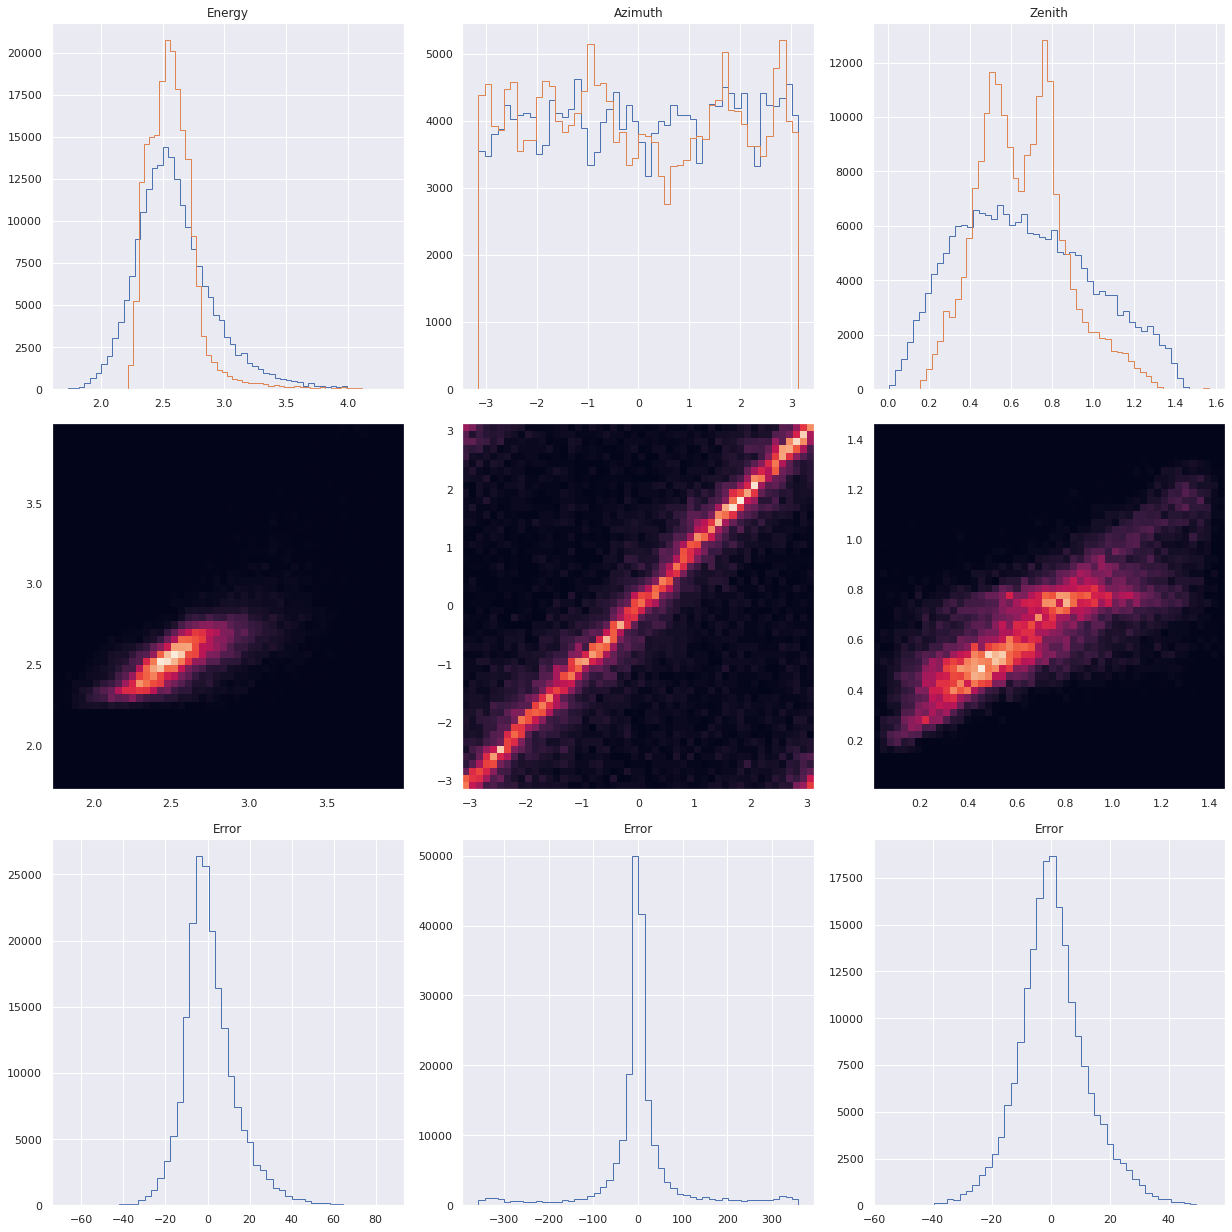

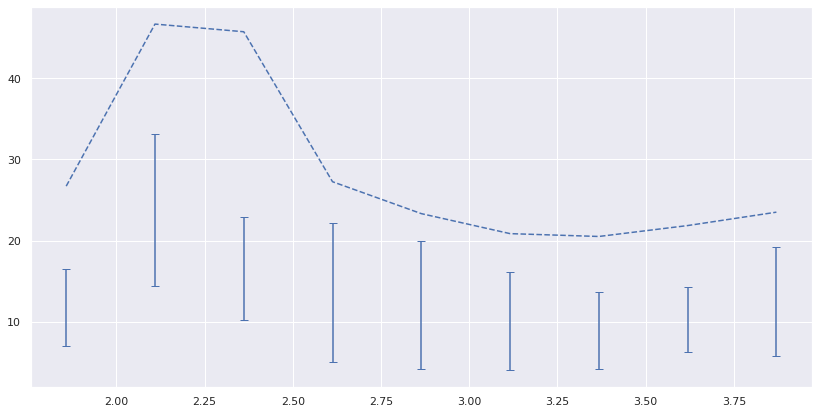

In [ ]:
# predictions, truths = test_model()
make_plots(predictions, truths)

Next step is recreating this:

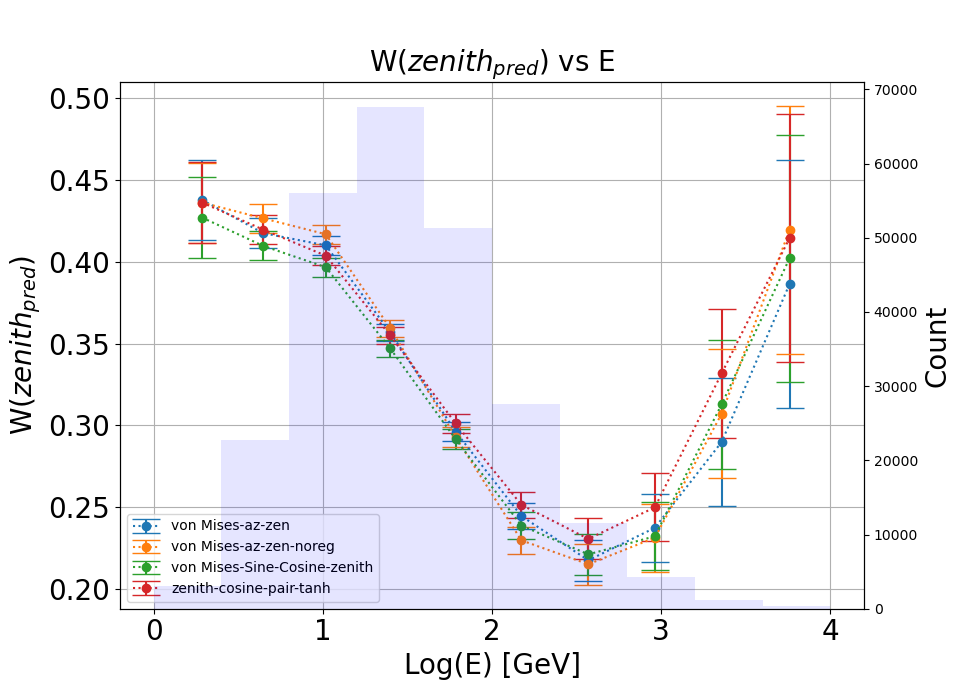